<a href="https://colab.research.google.com/github/juno-yuu/COVID-Vaccine-and-Biotech-industry/blob/Juno/Machine_Learning_Final_Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install plotly_express
!pip install linearmodels
!pip install pmdarima

In [2]:
import numpy as np
import pandas as pd
import time
import plotly_express as px
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
import scipy.stats as stats
from linearmodels.panel import PanelOLS, FamaMacBeth
from patsy              import dmatrices
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from fbprophet import Prophet
import pmdarima.arima as pm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
df= pd.read_csv("/content/drive/MyDrive/MFE 431 DAML /us_state_vaccinations.csv")
state = pd.read_csv("/content/drive/MyDrive/MFE 431 DAML /world_country_and_usa_states_latitude_and_longitude_values.csv")[['usa_state','usa_state_code']].dropna()
df = df.merge(state, left_on='location', right_on='usa_state')
df=df.drop(["usa_state"],axis=1)
df['daily_vaccinations_lagged'] = df['daily_vaccinations'].shift(1)

In [38]:
# data fill with last value
df=df.fillna(method='ffill')
df=df.fillna(0) # if no preceding value, fill na
# check location value
df.location.unique() #get all state variable


array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'North Carolina', 'North Dakota',
       'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [39]:
df['date']=pd.to_datetime(df['date'])

#determine the date range
print("start date: ",df.date.min())
print("latest date: ",df.date.max())

#number of vaccination days
dates_range_length = len(pd.date_range(df.date.min(), df.date.max()))
print("The date range equals ",dates_range_length," days.")

start date:  2021-01-12 00:00:00
latest date:  2021-05-16 00:00:00
The date range equals  125  days.


In [40]:
#add month to data frame
df['month'] = df.date.dt.month
#Date by Week Number
df['week'] = df.date.dt.week

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [41]:
#Month
df_month = df.groupby(['usa_state_code','month']).daily_vaccinations.sum().reset_index()


In [42]:
#Daily corona vaccinations on monthly basis
fig1 = px.choropleth(df_month,locations=df_month['usa_state_code'],color=df_month['daily_vaccinations'],
                     color_continuous_scale='YlOrRd',locationmode='USA-states',scope='usa',animation_frame=df_month['month'],
                     title="Vaccinations in the USA on monthly basis",labels={'daily_vaccinations':'Number of Vaccinations'})

fig1.show()


In [43]:
#Week
df_week = df.groupby(['usa_state_code','week']).daily_vaccinations.sum().reset_index()
df_week = df_week.sort_values(by=['week','usa_state_code'])

In [44]:
#Daily corona vaccinations on weekly basis
fig2 = px.choropleth(df_week,locations=df_week['usa_state_code'],color=df_week['daily_vaccinations'],
                     color_continuous_scale='YlOrRd',locationmode='USA-states',scope='usa',animation_frame=df_week['week'],
                     title="Vaccinations in the USA on weekly basis",labels={'daily_vaccinations':'Number of Vaccinations'})

fig2.show()

In [45]:
df['day'] = df.date.dt.day
df_daily = df.groupby(['usa_state_code','day']).daily_vaccinations.sum().reset_index()

In [46]:
#Daily corona vaccinations on monthly basis
fig3 = px.choropleth(df_daily,locations=df_daily['usa_state_code'],color=df_daily['daily_vaccinations'],
                     color_continuous_scale='YlOrRd',locationmode='USA-states',scope='usa',animation_frame=df_daily['day'],
                      title="Vaccinations in the USA on daily basis",labels={'daily_vaccinations':'Number of Vaccinations'})

fig3.show()

In [47]:
def plot_gb_time_series(df, ts_name, gb_name, value_name, figsize=(20,7), title=None):
    '''
    Runs groupby on Pandas dataframe and produces a time series chart.

    Parameters:
    ----------
    df : Pandas dataframe
    ts_name : string
        The name of the df column that has the datetime timestamp x-axis values.
    gb_name : string
        The name of the df column to perform group-by.
    value_name : string
        The name of the df column for the y-axis.
    figsize : tuple of two integers
        Figure size of the resulting plot, e.g. (20, 7)
    title : string
        Optional title
    '''
    xtick_locator = mdates.DayLocator(interval=1)
    xtick_dateformatter = mdates.DateFormatter('%m/%d/%Y')
    fig, ax = plt.subplots(figsize=figsize)
    for key, grp in df.groupby([gb_name]):
        ax = grp.plot(ax=ax, kind='line', x=ts_name, y=value_name, label=key, marker='o')
    ax.xaxis.set_major_locator(xtick_locator)
    ax.xaxis.set_major_formatter(xtick_dateformatter)
    ax.autoscale_view()
    ax.legend(loc='upper left')
    _ = plt.xticks(rotation=90, )
    _ = plt.grid()
    _ = plt.xlabel('')
    _ = plt.ylim(0, df[value_name].max() * 1.25)
    _ = plt.ylabel(value_name)
    if title is not None:
        _ = plt.title(title)
    _ = plt.show()

In [48]:
df

,date,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used,usa_state_code,daily_vaccinations_lagged,month,week,day
0,2021-01-12,Alabama,78134.0,377025.0,70861.0,0.15,1.59,7270.0,1.45,7.69,0.0,0.0,0.0,0.207,AL,0.0,1,2,12
1,2021-01-13,Alabama,84040.0,378975.0,74792.0,0.19,1.71,9245.0,1.53,7.73,5906.0,5906.0,1205.0,0.222,AL,0.0,1,2,13
2,2021-01-14,Alabama,92300.0,435350.0,80480.0,0.19,1.88,9245.0,1.64,8.88,8260.0,7083.0,1445.0,0.212,AL,5906.0,1,2,14
3,2021-01-15,Alabama,100567.0,444650.0,86956.0,0.28,2.05,13488.0,1.77,9.07,8267.0,7478.0,1525.0,0.226,AL,7083.0,1,2,15
4,2021-01-16,Alabama,100567.0,444650.0,86956.0,0.28,2.05,13488.0,1.77,9.07,7557.0,7498.0,1529.0,0.226,AL,7478.0,1,2,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6370,2021-05-12,Wyoming,374624.0,491255.0,202711.0,29.92,64.73,173179.0,35.03,84.88,1287.0,1639.0,2832.0,0.763,WY,1734.0,5,19,12
6371,2021-05-13,Wyoming,374754.0,491795.0,202831.0,29.95,64.75,173312.0,35.05,84.97,130.0,1623.0,2804.0,0.762,WY,1639.0,5,19,13
6372,2021-05-14,Wyoming,376441.0,492695.0,203422.0,30.14,65.04,174440.0,35.15,85.13,1687.0,1270.0,2194.0,0.764,WY,1623.0,5,19,14
6373,2021-05-15,Wyoming,378677.0,495435.0,204468.0,30.34,65.43,175581.0,35.33,85.60,2236.0,1272.0,2198.0,0.764,WY,1270.0,5,19,15


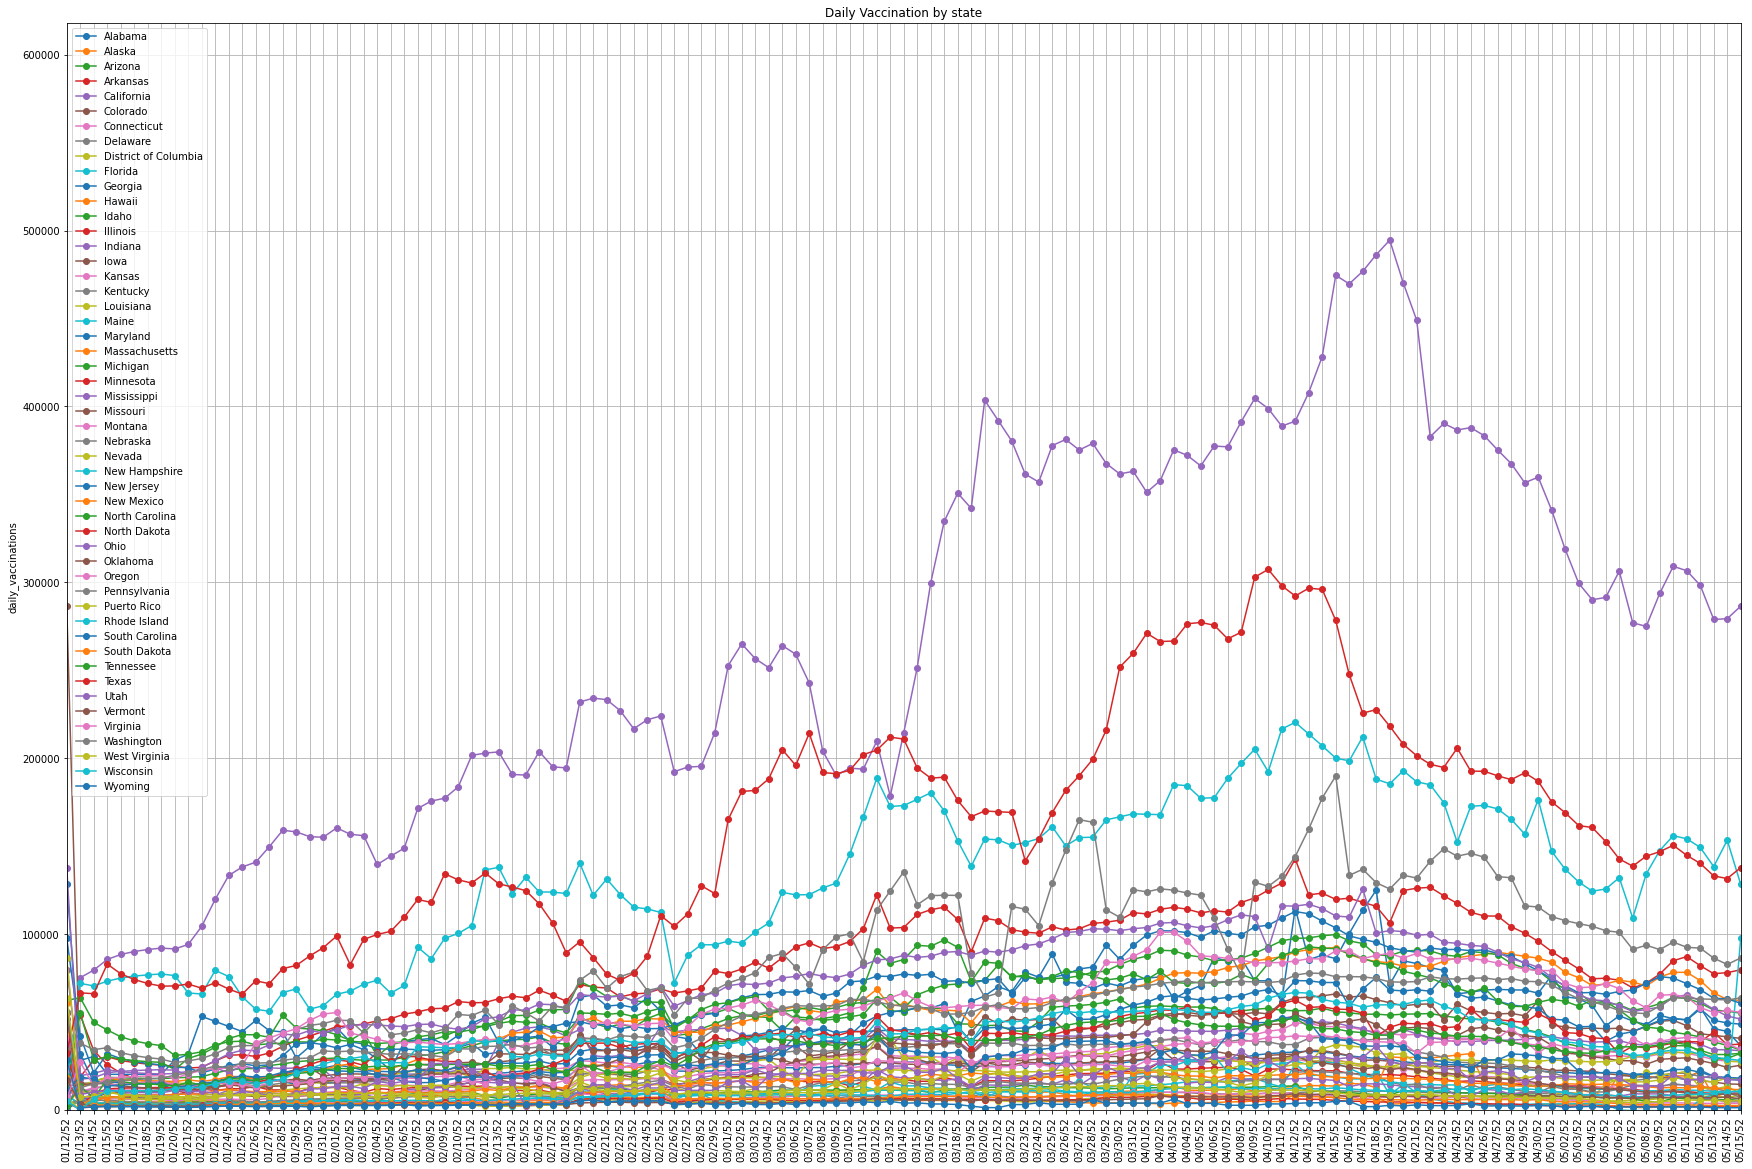

In [17]:
plot_gb_time_series(df, 'date', 'location', 'daily_vaccinations',
                    figsize=(30, 20), title="Daily Vaccination by state")

In [18]:
#define FMB regreesion
def fmreg(data,formula):
  return smf.ols(formula,data=data).fit().params[:]

# define output of the regression
def fm_summary(p):
  s = p.describe().T
  s['std_error'] = s['std']/np.sqrt(s['count'])
  s['tstat'] = s['mean']/s['std_error']
  s['Sharpe Ratio'] = s['mean']/s['std']
  return s[['mean','std','tstat','Sharpe Ratio']]

In [53]:
out_panel = PanelOLS.from_formula(formula='daily_vaccinations~ 1+ daily_vaccinations_lagged', data=df).fit()

PatsyError: ignored